In [96]:
import astropy
import astropy.units as u
import numpy as np
import specutils
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import FunctionLib as FL

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, append=True)

In [ ]:
DJA_File_Path_str=os.path.expanduser('./DJAData/')
DJA_Catalog_DataFrame=pd.read_csv('./DJACatalog.csv')

if os.path.exists(DJA_File_Path_str):
    DJA_File_list=np.array(os.listdir(DJA_File_Path_str))
print('Number of files in DJA directory:', len(DJA_File_list))

In [ ]:
DJA_File_List=[f for f in os.listdir('./') if f.startswith('goodsn')]
print('Number of files in current directory:', len(DJA_File_List))

In [ ]:
redshift=FL.Load_Redshift(DJA_Catalog_DataFrame, DJA_File_List[1])
print('Redshift:', redshift)

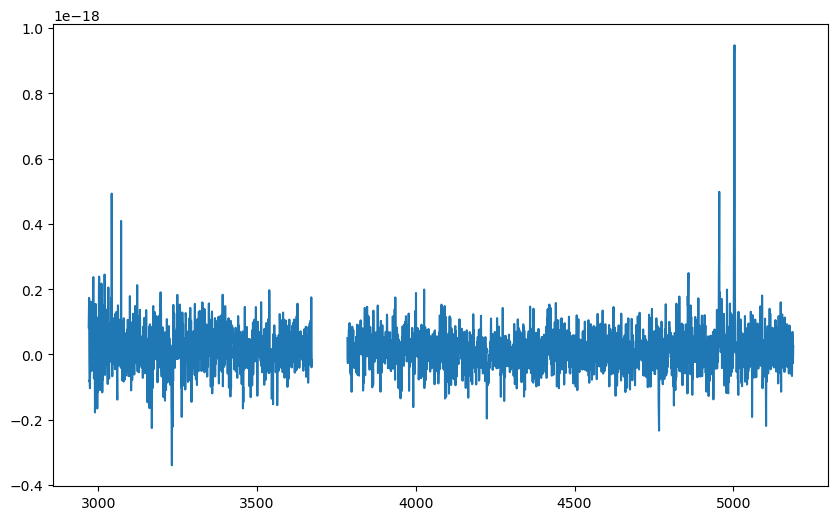

In [117]:
Spectrum=FL.Load_N_Rescale_Spectra(os.path.join(DJA_File_Path_str, DJA_File_List[2]))
Spectrum=FL.Calibrate_Spectra_To_RestFrame(Spectrum, redshift)
plt.figure(figsize=(10, 6))
plt.plot(Spectrum.wavelength, Spectrum.flux, label='Rest Frame Spectrum')

In [ ]:
Spectrum.flux

In [ ]:
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.fitting import find_lines_threshold, find_lines_derivative
from astropy import units as u
from astropy.modeling import models

(4500.0, 5000.0)

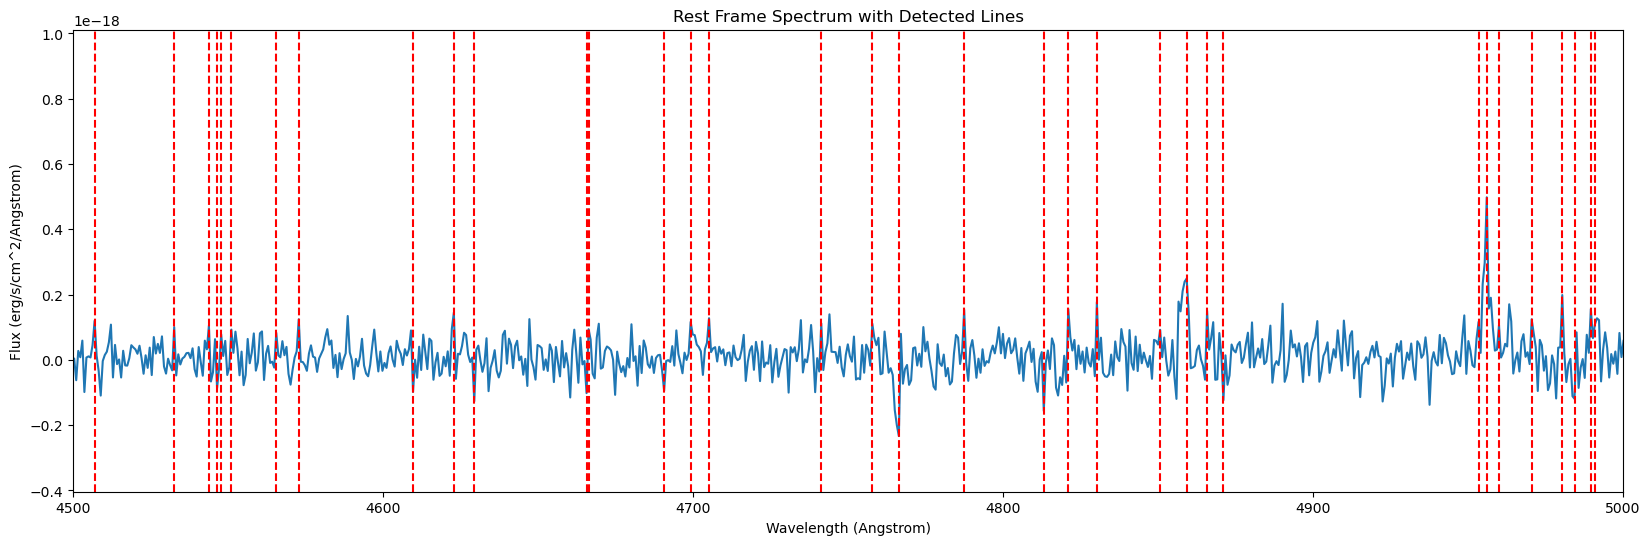

In [124]:
lines= find_lines_threshold(Spectrum, noise_factor=2.5)
plt.figure(figsize=(20,6))
plt.plot(Spectrum.wavelength, Spectrum.flux, label='Rest Frame Spectrum')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Rest Frame Spectrum with Detected Lines')
for line in lines:
    plt.axvline(x=line[0].to(u.AA).value, color='red', linestyle='--')

plt.xlim(4500,5000)

In [106]:
Spectrum.wavelength

<SpectralAxis [2898.2977059 , 2898.95618318, 2899.61466045, ..., 5532.86528596,
   5533.52376324, 5534.18224051] Angstrom>

(4700.0, 5100.0)

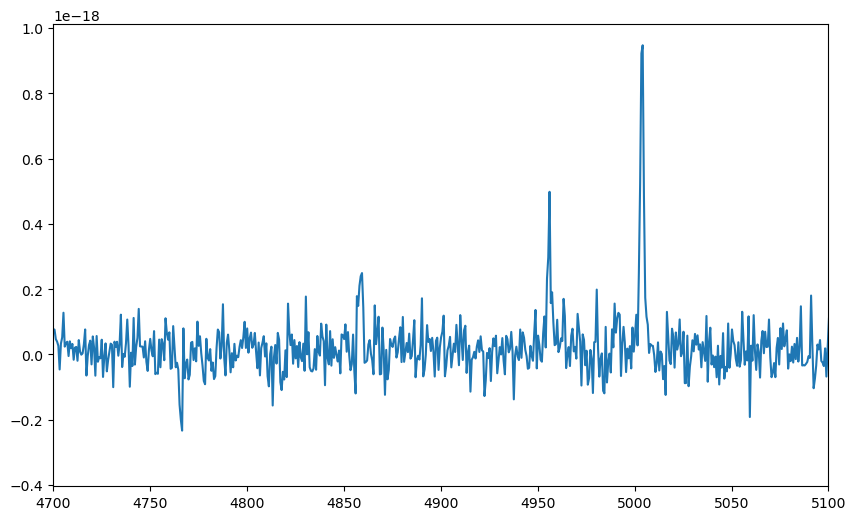

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(Spectrum.wavelength, Spectrum.flux, label='Rest Frame Spectrum')
plt.xlim(4700,5100)

In [66]:
left=Spectrum.wavelength.value[np.where(Spectrum.wavelength.value-4850<0)[0][-1]]
right=Spectrum.wavelength.value[np.where(Spectrum.wavelength.value-4950>0)[0][0]]

In [73]:

spectral_axis = Spectrum.spectral_axis
mask = (spectral_axis >= left*u.AA) & (spectral_axis <= right*u.AA)
indices = np.where(mask)[0]

if len(indices) > 0:
    start_idx, end_idx = indices[0], indices[-1] + 1

    # Create new spectrum directly
    sub_spectrum = specutils.Spectrum1D(
        flux=Spectrum.flux[start_idx:end_idx],
        spectral_axis=Spectrum.spectral_axis[start_idx:end_idx],
        uncertainty=Spectrum.uncertainty[start_idx:end_idx] if hasattr(Spectrum, 'uncertainty') and Spectrum.uncertainty is not None else None
    )

In [74]:
sub_spectrum

<Spectrum1D(flux=[5.820338835248173e-20 ... 5.750545754623964e-20] erg / (Angstrom s cm2) (shape=(154,), mean=0.00000 erg / (Angstrom s cm2)); spectral_axis=<SpectralAxis [0.48493659 0.48500244 0.48506828 ... 0.49487959 0.49494544 0.49501129] micron> (length=154); uncertainty=StdDevUncertainty)>

In [108]:
def Gaussian(x, amplitude, mean, sigma, offset=0):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2)) + offset

In [119]:
wavelength=Spectrum.spectral_axis.value

flux=Spectrum.flux.value
#if nan in flux:
flux=np.nan_to_num(flux, nan=0.0)

In [120]:
amplitude_guess=np.max(flux)-np.min(flux)
mean_guess=wavelength[np.argmax(flux)]
sigma_guess=(wavelength[-1]-wavelength[0])/10
offset_guess=np.min(flux)
initial_guess = [amplitude_guess, mean_guess, sigma_guess, offset_guess]

In [97]:
from scipy.optimize import curve_fit


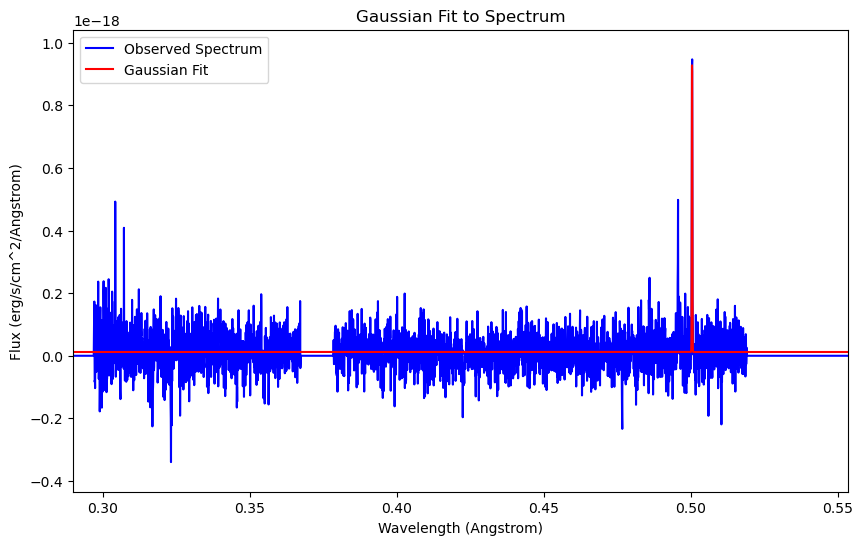

Fitted parameters:
Amplitude: 9.699425955923148e-19
Mean: 0.5003752834568564
Sigma: 8.95466150792115e-05
Offset: 1.2039574642488112e-20


In [121]:

popt, pcov = curve_fit(Gaussian, wavelength, flux, p0=initial_guess,maxfev=800000)
amp_fit, mean_fit, sigma_fit, offset_fit = popt

x_fit= wavelength
y_fit = Gaussian(x_fit, *popt)
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Observed Spectrum', color='blue')
plt.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Gaussian Fit to Spectrum')
plt.legend()
plt.xlim(wavelength[0], wavelength[-1])
plt.ylim(np.min(flux)-0.1*np.max(flux), np.max(flux)+0.1*np.max(flux))
plt.show()
print(f"Fitted parameters:\nAmplitude: {amp_fit}\nMean: {mean_fit}\nSigma: {sigma_fit}\nOffset: {offset_fit}")

In [122]:
wavelength=wavelength[np.where((wavelength>=0.45) & (wavelength<=0.52))[0]]
flux=flux[np.where((wavelength>=0.45) & (wavelength<=0.52))[0]]

Text(0.5, 0, 'Wavelength (Angstrom)')

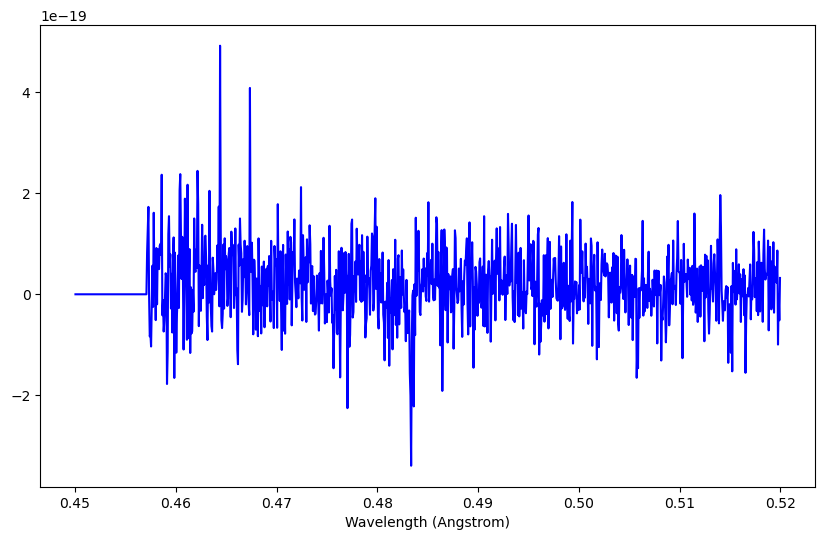

In [123]:
flux=flux
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Observed Spectrum', color='blue')
plt.xlabel('Wavelength (Angstrom)')

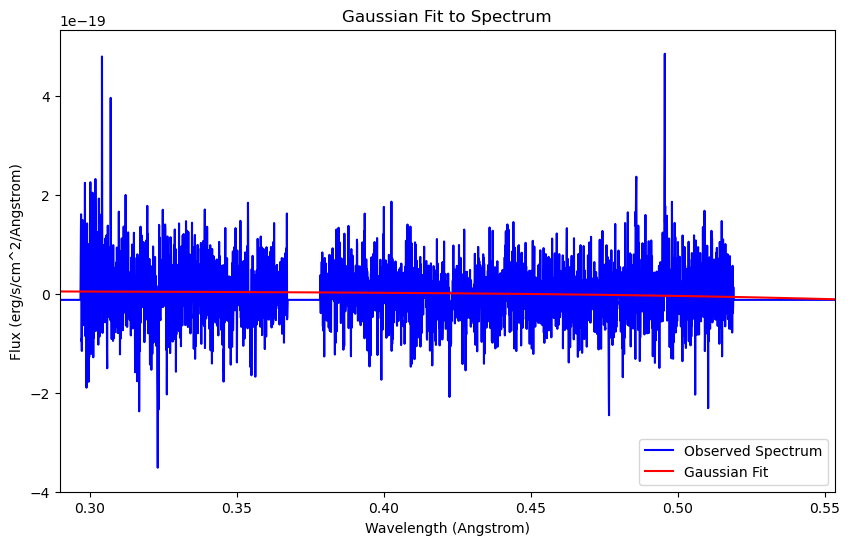

Fitted parameters:
Amplitude: -1.3064815248340225e-11
Mean: 4.9403298565099885
Sigma: -0.685922269971407
Offset: 6.3017981015824886e-21


In [114]:
popt, pcov = curve_fit(Gaussian, wavelength, flux, p0=initial_guess, maxfev=800000)
amp_fit, mean_fit, sigma_fit, offset_fit = popt

x_fit= wavelength
y_fit = Gaussian(x_fit, *popt)
plt.figure(figsize=(10, 6))
plt.plot(wavelength, flux, label='Observed Spectrum', color='blue')
plt.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Gaussian Fit to Spectrum')
plt.legend()
plt.xlim(wavelength[0], wavelength[-1])
plt.ylim(np.min(flux)-0.1*np.max(flux), np.max(flux)+0.1*np.max(flux))
plt.show()
print(f"Fitted parameters:\nAmplitude: {amp_fit}\nMean: {mean_fit}\nSigma: {sigma_fit}\nOffset: {offset_fit}")

In [ ]:
Sample_Indices_list=list()
for Index_In_DJA_Catalog_int in range(len(DJA_Catalog_DataFrame)):

    Redshift_float=DJA_Catalog_DataFrame['z'][Index_In_DJA_Catalog_int]

    if (Redshift_float<4)or (Redshift_float>6.5):
        continue

    Spectra_NGrating_int=DJA_Catalog_DataFrame.nGr[Index_In_DJA_Catalog_int]
    if Spectra_NGrating_int<2:
        continue

    Sample_Indices_list.append(Index_In_DJA_Catalog_int)

print('Sample number:', len(Sample_Indices_list))
Sample_Indices_list=np.array(Sample_Indices_list)

FL.Free('Index_In_DJA_Catalog_int')

In [ ]:
for DJA_Catalog_DataFrame_Index_int in Sample_Indices_list:

    Object_Catalog_Dataframe=DJA_Catalog_DataFrame[DJA_Catalog_DataFrame.index==DJA_Catalog_DataFrame_Index_int]

    Object_Prism_fits_File_Name_str=Object_Catalog_Dataframe.file.values[0]
    Object_NGrating_int=Object_Catalog_Dataframe.nGr.values[0]
    Object_Grating_List_str=Object_Catalog_Dataframe.Grating.values[0]
    Object_Redshift_float=Object_Catalog_Dataframe.z.values[0]

    for Grating_Type_str in Object_Grating_List_str.split('   '):
        Grating_Type_str=Grating_Type_str.strip().lower()

        Disperser_Name_str=Grating_Type_str[1:-1]

        Dual_Filter_Flag=False

        if Disperser_Name_str=='140':
            Dual_Filter_Flag=True
            Disperser_Filter_Combination_070_str=Grating_Type_str+'-f070lp'
            Disperser_Filter_Combination_100_str=Grating_Type_str+'-f100lp'
        elif Disperser_Name_str=='235':
            Dual_Filter_Flag=False
            Disperser_Filter_Combination_Single_str=Grating_Type_str+'-f170lp'
        elif Disperser_Name_str=='395':
            Dual_Filter_Flag=False
            Disperser_Filter_Combination_Single_str=Grating_Type_str+'-f290lp'

        if Dual_Filter_Flag:
            try:
                Grating_070_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_070_str)
                Grating_100_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_100_str)

                if not os.path.exists(DJA_File_Path_str+Grating_070_fits_File_Name_str) or not os.path.exists(DJA_File_Path_str+Grating_100_fits_File_Name_str):
                    print('File not found:', Grating_070_fits_File_Name_str, Grating_100_fits_File_Name_str)
                    continue
                else:
                    print('1')

            except Exception as e:
                print('Error processing dual filter grating:', e)
                continue
        else:
            try:
                Grating_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_Single_str)
                if not os.path.exists(DJA_File_Path_str+Grating_fits_File_Name_str):
                    print('File not found:', Grating_fits_File_Name_str)
                    continue
                else:
                    print('1')
            except Exception as e:
                print('Error processing single filter grating:', e)
                continue







In [ ]:
df= pd.read_csv('./DJACatalog.csv')
df

In [ ]:
8974+10804

In [ ]:
df.nGr.sum()